In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### 1. Vary some input **parameter** other than temperature to give three distinct simulations 

I chose to vary coulombtype:
1. <b>Cut-off</b>
> - Twin range cut-offs with neighborlist cut-off rlist 
> - I think this was set to the default using verlet as the cutoff scheme?

2. <b>Reaction-Field-zero (RFZ)</b>
> - makes the potential zero beyond the cut-off to solve bad energy conservation that occurs from using cutoff-scheme = group (I did not change the cut off scheme to this, probably affected the results)
> - same as PME, but slower?

3. <b>PME</b>

> - charges are assigned to a grid using interpolation (B-spline, also called smooth PME). The grid is then Fourier transformed with a 3D FFT algorithm and the reciprocal energy term obtained by a single sum over the grid in k-space. The potential at the grid points is calculated by inverse transformation, and by using the interpolation factors we get the forces on each atom. In summary: efficient way to assign charge to large explicit systems
> - Faster than EWALD on medium-large systems
> - the PME direct space potential is shifted by a constant such that the potential is zero at the cut-off

In [ ]:
#from wrapper file

name=(cutoff RFZ pme)
dimensions=(Cut-off Reaction-Field-zero PME)

for (( i=0 ; i<=2 ; i++ )) ; do
        currentdim=${dimensions[$i]}
        cname=${name[$i]}
        cp input.inp ${cname}.inp
        echo ${currentdim}
        sed -i "8s/.*/CType=${currentdim}/" ${cname}.inp

        source master.sh ${cname} > ${cname}.log &
done

### 2. Run script with a new automated analyses that you expect to be affected by your parameter

I chose the gmx potential command which calculates the electrostatic potential across the box. 
- The potential is calculated by first summing the charges per slice (0.3 nm) and then integrating twice of this charge distribution.
- Periodic boundary conditions are not taken into account


In [ ]:
##calculate index to use in gmx potential
if [ ! -f index.ndx ] ; then
        echo "calculating index for ${name}"
        echo q | gmx make_ndx -f conf.gro -o index.ndx
fi

#calculate potential using gmx potential
if [ ! -f potential.xvg ] && [ ! -f charge.xvg ] && [ ! -f field.xvg ] ; then
        echo "calculating potential for ${name}"
        echo 0 | gmx potential -f traj_comp.xtc -n index.ndx -s topol.tpr -o potenital.xvg -oc charge.xvg -of field.xvg
fi

### 3. Form a hypothesis on how this analysis will be different for the three runs and justify (1 paragraph)

The parameter for coulombtype provides the method for calculating longrange electrostatics. I proposed that running the gmx potential command would be a good indicator of which coulombtype would provide the most accurate model for the system of interest. I predicted that the best calculation method would output a potential close to zero over the range of the box, and have an average charge and field of 0 q/nm and 0 V respectively. I predicted pme to show the best results for this system. 

### 4. Create plots for your analysis using python and state whether your hypothesis was falsified or not

In [122]:
charge_RFZ=pd.read_csv('charge_RFZ.xvg',delimiter = ' ',skiprows=23, skipinitialspace=True, usecols=[0,1], header=None, names=['box','charge'])
charge_pme=pd.read_csv('charge_pme.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','charge'])
charge_cutoff=pd.read_csv('charge_cutoff.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','charge'])

field_RFZ=pd.read_csv('field_RFZ.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','field'])
field_pme=pd.read_csv('field_pme.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','field'])
field_cutoff=pd.read_csv('field_cutoff.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','field'])

potential_RFZ=pd.read_csv('potenital_RFZ.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','pot'])
potential_pme=pd.read_csv('potenital_pme.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','pot'])
potential_cutoff=pd.read_csv('potenital_cutoff.xvg',delimiter = ' ',skiprows=23,comment='#', skipinitialspace=True, usecols=[0,1], header=None, names=['box','pot'])


In [132]:
plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 3,
    'axes.labelsize': 8,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
   }
plt.rcParams.update(params)

csfont = {'fontname':'Comic Sans MS'}

RFZ average:  -5.55111512313e-18
pme average:  1.38777878078e-18
cutoff average:  0.0


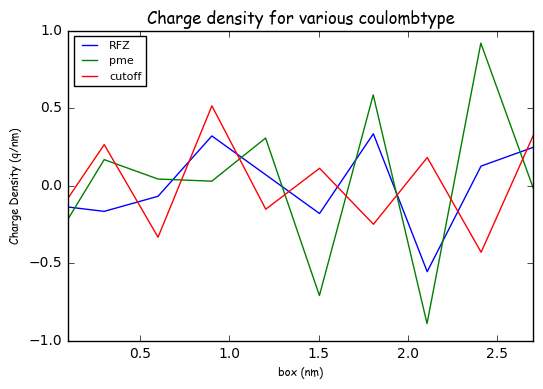

In [144]:
plt.plot(charge_RFZ.box,charge_RFZ.charge, label='RFZ')
plt.plot(charge_pme.box,charge_pme.charge,label='pme')
plt.plot(charge_cutoff.box,charge_cutoff.charge,label='cutoff')
plt.legend(loc='upper left')
plt.title('Charge density for various coulombtype',**csfont)
plt.xlabel('box (nm)',**csfont)
plt.ylabel('Charge Density (q/nm)',**csfont)
plt.xlim([0.1,2.7])
plt.ylim([-1,1])

print('RFZ average: ',np.average(charge_RFZ.charge))
print('pme average: ', np.average(charge_pme.charge))
print('cutoff average: ', np.average(charge_cutoff.charge))

RFZ average:  -0.416418085781
pme average:  -0.128829990499
cutoff average:  0.393534413156


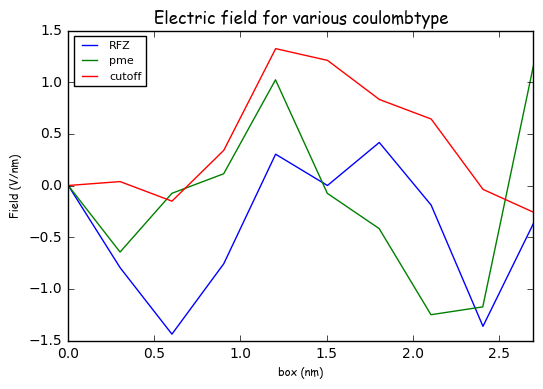

In [147]:
plt.plot(field_RFZ.box,field_RFZ.field, label='RFZ')
plt.plot(field_pme.box,field_pme.field,label='pme')
plt.plot(field_cutoff.box,field_cutoff.field,label='cutoff')
plt.legend(loc='upper left')
plt.title('Electric field for various coulombtype',**csfont)
plt.xlabel('box (nm)',**csfont)
plt.ylabel('Field (V/nm)',**csfont)
plt.xlim([0,2.7])
plt.ylim([-1.5,1.5])

print('RFZ average: ',np.average(field_RFZ.field))
print('pme average: ', np.average(field_pme.field))
print('cutoff average: ', np.average(field_cutoff.field))

RFZ average:  0.663178930637
pme average:  0.173281375533
cutoff average:  -0.555947533189


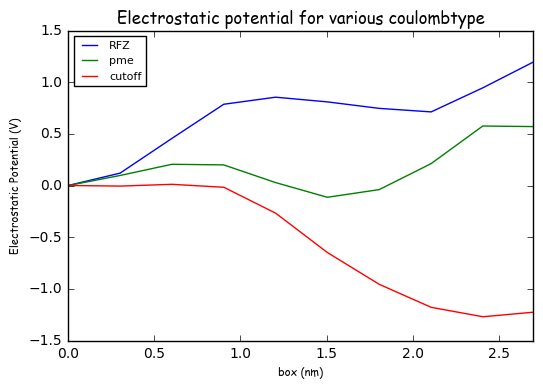

In [149]:
plt.plot(potential_RFZ.box,potential_RFZ.pot, label='RFZ')
plt.plot(potential_pme.box,potential_pme.pot,label='pme')
plt.plot(potential_cutoff.box,potential_cutoff.pot,label='cutoff')
plt.legend(loc='upper left')
plt.title('Electrostatic potential for various coulombtype',**csfont)
plt.xlabel('box (nm)',**csfont)
plt.ylabel('Electrostatic Potential (V)',**csfont)
plt.xlim([0,2.7])

print('RFZ average: ',np.average(potential_RFZ.pot))
print('pme average: ', np.average(potential_pme.pot))
print('cutoff average: ', np.average(potential_cutoff.pot))

### Results

As shown in the electrostatic potential plots, pme showed to be the most stable over the length of the box. This was expected as pme should be the most stable for this system. Possible points of error in these graphs could be due to not changing other electrostatic parameters when changing the coulombtype. 

### Things I didn't realize until 12pm last night:
Each coulombtype requires a whole set of different parameters for electrostatics (rvdw, fourier spacing, pme-order, etc.). I did not account for each parameter in my wrapper
> <b>Solution</b>: Include an entire set of parameters to describe electrostatics in my wrapper file. 




### Further Work

- compare coulombtypes and optimize them for different parameters? (e.g. the performance of various coulombtype's for various system size's)
- look at more coulombtype's

In [ ]:
##from my nvt input file

; Electrostatic
cutoff-scheme           = Verlet
rcoulomb                = 1.0
coulombtype             = pme
fourierspacing          = 0.12
;periodic_molecules     = yes